# Construction du dataset pour la Reconnaissance Optique de caractère et préprocessing à partir du fichier csv fabriqué par le notebook "NIST-indexing"

Dans ce notebook sera présenté le pré-traitement du jeu de donnée [NIST 2nd](https://www.nist.gov/srd/nist-special-database-19) afin d'obtenir un nouveau jeu de donnée données plus facilement utilisable pour notre algorithme de reconnaissance de caractère

Ce pré-traitement de donnée aura plusieurs objectifs :
- Charger les images du dataset
- Appliquer des pré-traitements sur celle-ci
- Fabriquer un set d'entrainement et un set de test

**structure du nouveau dataset obtenu:**
 - NIST-dataset
    - train_set
        - a
            - a000001.png
            - a000002.png
            ...
            ...
            - a00000n.png
        - b ....
        ...
        - z ...
    - test_set
        - a
            - a000001.png
            - a000002.png
            ...
            ...
            - a00000n.png
        - b ....
        ...
        - z ...

## Importation des dépendances

In [1]:
import os
from os import path, mkdir
import multiprocessing as mp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize, rescale
from skimage.util import crop

## Chargement du dataframe obtenu par le notebook indexing

In [2]:
dataset_indexing_frame = pd.read_csv("../../data/processed/NIST-dataset/nist.csv", chunksize=10)
sample_indexing_frame = next(dataset_indexing_frame)

## Définition des parmètres souhaités pour le prétraitement des image

In [3]:
NEW_IMAGE_SIZE = (50, 50)
PERCENT_OF_TRAIN_SET = 0.7
CROP_PX = 30
RESCALE_PERCENT = 0.6
INPUT_INDEXED_DATASET = "../../data/processed/NIST-dataset/nist.csv"
OUTPUT_PROCESSED_DATASET = "../../data/processed/NIST-dataset/"
CHUNKSIZE = 25000

## Définition de la fonction de prétraitement d'image
Les objectifs du prétraitement des images sont de réduire la dimension des images afin de faciliter l'entrainement de notre modèle.
Pour ce faire, lors du prétraitement, nous allons transformer l'image *rgb* en image *noire et blanche*. Toujours pour réduire la dimension de l'image, on va effectuer un rognage sur les bords de celle-ci afin de garder uniquement les informations essentielles de l'image c'est-à-dire le dessin de la lettre. Et pour finir on va redimensionner l'image pour réduire une fois de plus sa *dimension*.

In [4]:
def preprocessing(image_path):
    img = plt.imread(image_path)
    img_gray_scale = rgb2gray(img)
    img_gray_scale_cropped = crop(img_gray_scale, CROP_PX)
    image_processed = rescale(img_gray_scale_cropped, RESCALE_PERCENT)

    return np.round(image_processed, decimals=0).astype(np.uint8)

In [5]:
image_number = 5
image_path = path.join(sample_indexing_frame["old_path"][image_number], sample_indexing_frame["old_file_name"][image_number])
original_image = plt.imread(image_path)
preprocessed_img = preprocessing(image_path)
preprocessed_img.dtype

dtype('uint8')

Avant prétraitement

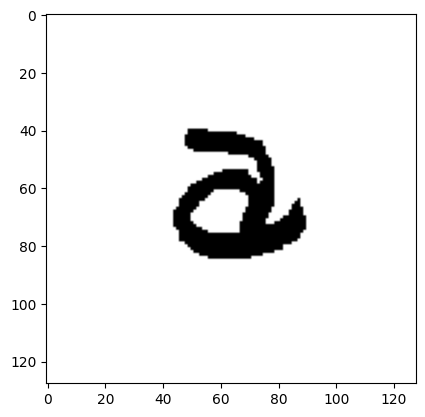

In [6]:
plt.imshow(original_image)
plt.show()

Après prétraitement

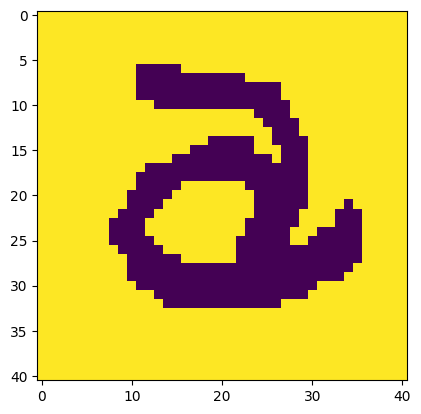

In [7]:
plt.imshow(preprocessed_img)
plt.show()

Comparaison des dimensions des images avant et après le prétraitement.

In [8]:
print(original_image.shape)
print(preprocessed_img.shape)

(128, 128, 3)
(41, 41)


## Sauvegarde du dataest avec les images prétraités

Dans cette section, nous allons définir les fonctions qui nous permettront de sauvegarder notre dataset prétraité sur le disque en interprétant les informations du dataframe indexé.

### Fonction de sauvegarde du dataframe

Cette fonction est chargée de sauvegarder de prétraiter les images et de les sauvegarder au bon endroit conformément au dataframe passé en paramètre

In [9]:
def get_labeled_processed_img(dataframe):
    data = []
    for index, row in dataframe.iterrows():
        image_old_path = path.join(row["old_path"], row["old_file_name"])
        label = row["letter"]
        pretreated_img = preprocessing(image_old_path)
        data.append((label, pretreated_img))

    return data

In [10]:
def get_compatible_x_shape_for_save(x_set):
    x, y, z = x_set.shape
    return x_set.reshape(x, y * z)

In [11]:
def get_labeled_processed_img_dataframe(dataframe):
    data = get_labeled_processed_img(dataframe)
    y_raw_set, x_raw_set = list(zip(*data))
    y_set = np.array(y_raw_set)
    x_set = get_compatible_x_shape_for_save(np.array(x_raw_set))

    x_set_frame = pd.DataFrame(x_set, columns=[f"x{i}" for i in range(x_set.shape[1])])
    y_set_frame = pd.DataFrame(y_set, columns=["label"])

    return pd.concat([y_set_frame, x_set_frame], axis=1)

In [12]:
def get_labeled_processed_img_dataframe_multi_proc(path, engine, chunk_size):
    chunks = pd.read_csv(path, chunksize=chunk_size, engine=engine)
    cpu_count = mp.cpu_count()

    with mp.Pool(cpu_count) as pool:
        dataframe_list = [data for data in pool.map(get_labeled_processed_img_dataframe, chunks)]

    return pd.concat(dataframe_list, ignore_index=True)

### Fabriquer le train set et le test set

 Pour cela nous avons la fonction définie ci-dessous est chargée de séparer le dataset indexé initial contenu dans un dataframe pour enfin retourner un dataframe contenant le train set et un autre dataframe contenant le test set

In [13]:
def get_train_and_test_set(dataframe, percent_of_train):
        dataframe_train = dataframe.sample(frac=percent_of_train, random_state=60)
        dataframe_test = dataframe[~dataframe.isin(dataframe_train)].dropna() # Sélectionne les éléments de dataframe qui ne sont pas dans dataframe_train

        return dataframe_train, dataframe_test

### On utilise les fonctions définis dans ci-dessus afin de sauvegarder proprement le dataset

In [14]:
dataset_processed_frame = get_labeled_processed_img_dataframe_multi_proc(INPUT_INDEXED_DATASET, engine="c", chunk_size=CHUNKSIZE)
df_train, df_test = get_train_and_test_set(dataset_processed_frame, PERCENT_OF_TRAIN_SET)

train_dir = path.join(OUTPUT_PROCESSED_DATASET, "train")
test_dir = path.join(OUTPUT_PROCESSED_DATASET, "test")

if not os.path.exists(train_dir):
    mkdir(train_dir)
if not os.path.exists(test_dir):
    mkdir(test_dir)

df_train.to_csv(path.join(train_dir, "nist_processed_train.csv"))
df_test.to_csv(path.join(test_dir, "nist_processed_test.csv"))